In [1]:
#data handling
#!pip install --upgrade scikit-learn
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

#feature selection
from sklearn.feature_selection import mutual_info_classif

#classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# performance metrics
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score,f1_score,precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

In [2]:
#read data directly from a github repository

file_url='https://github.com/vappiah/Machine-Learning-Tutorials/raw/main/datasets/cancer_gene_expression.zip'

dataframe=pd.read_csv(file_url)

In [3]:
#let's check the number of samples and features
#note:the last column contain the labels. it is not considered as a feature

print(dataframe.shape)
#let's check some of the columns (first, second and third columns)
print(dataframe.columns[0:3])
#lets check the name of the last column of this dataframe

dataframe.columns[-1]
#check for missing values
datanul=dataframe.isnull().sum()
g=[i for i in datanul if i>0]

print('columns with missing values:%d'%len(g))

(801, 8001)
Index(['gene_1', 'gene_2', 'gene_3'], dtype='object')
columns with missing values:0


Cancer_Type
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64


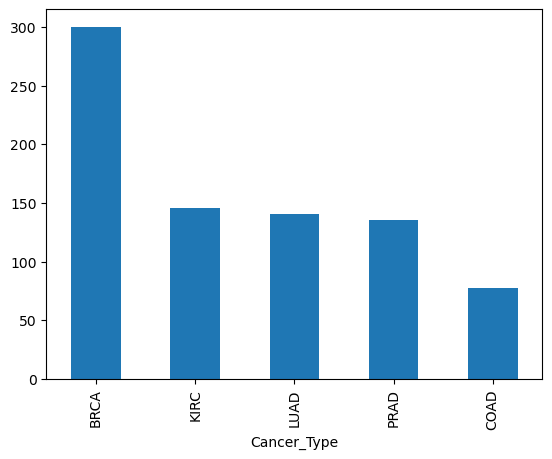

In [4]:
#let's check how many different cancer types are there in the data
#note: in this tutorial the cancer types will be referred to as classes or labels

print(dataframe['Cancer_Type'].value_counts())

#plot a bar chat to display the class distribution

dataframe['Cancer_Type'].value_counts().plot.bar()

#we will now seperate the feature values from the class. we do this because scikit-learn requires that features and class are separated before parsing them to the classifiers.

X=dataframe.iloc[:,0:-1]
y=dataframe.iloc[:,-1]

X.shape
y.shape
#let's encode target labels (y) with values between 0 and n_classes-1.
#encoding will be done using the LabelEncoder
label_encoder=LabelEncoder()
label_encoder.fit(y)
y_encoded=label_encoder.transform(y)
labels=label_encoder.classes_
classes=np.unique(y_encoded)
labels
classes
#split data into training and test sets
X_train,X_test,y_train,y_test=train_test_split(X,y_encoded,test_size=0.2,random_state=42)
dataframe.iloc[:,0:10].describe()
# scale data between 0 and 1

min_max_scaler=MinMaxScaler()
X_train_norm=min_max_scaler.fit_transform(X_train)
X_test_norm=min_max_scaler.fit_transform(X_test)

MI=mutual_info_classif(X_train_norm,y_train)
#select top n features. lets say 300.
#you can modify the value and see how the performance of the model changes

n_features=300
selected_scores_indices=np.argsort(MI)[::-1][0:n_features]
X_train_selected=X_train_norm[:,selected_scores_indices]
X_test_selected=X_test_norm[:,selected_scores_indices]
X_train_selected.shape
X_test_selected.shape
#Random Forest Classifier
#because we are dealing with multiclass data, the one versus rest strategy is used.
#learn to predict each class against the other.

RF=OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
RF.fit(X_train_selected,y_train)
y_pred =RF.predict(X_test_selected)
pred_prob = RF.predict_proba(X_test_selected)


accuracy:0.9550
precision:0.9695
recall:0.9689
f1score:0.9687


classification report


              precision    recall  f1-score   support

        BRCA       0.95      0.98      0.97        60
        COAD       1.00      0.88      0.93        16
        KIRC       1.00      1.00      1.00        28
        LUAD       0.92      0.92      0.92        24
        PRAD       1.00      1.00      1.00        33

    accuracy                           0.97       161
   macro avg       0.97      0.96      0.96       161
weighted avg       0.97      0.97      0.97       161



NameError: name 'plot_confusion_matrix' is not defined

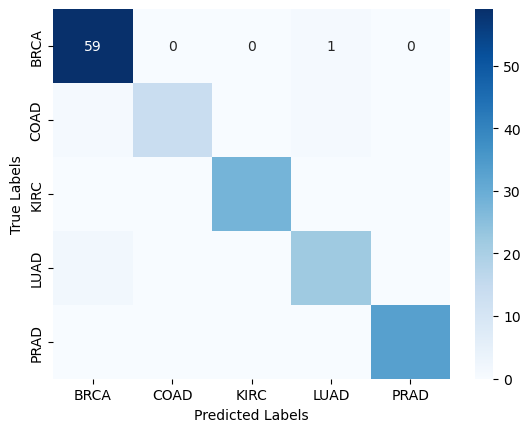

In [5]:
#accuracy
accuracy=np.round(balanced_accuracy_score(y_test,y_pred),4)
print('accuracy:%0.4f'%accuracy)

#precision
precision=np.round(precision_score(y_test,y_pred,average = 'weighted'),4)
print('precision:%0.4f'%precision)

#recall
recall=np.round(recall_score(y_test,y_pred,average = 'weighted'),4)
print('recall:%0.4f'%recall)

#f1score
f1score=np.round(f1_score(y_test,y_pred,average = 'weighted'),4)
print('f1score:%0.4f'%f1score)


report=classification_report(y_test,y_pred, target_names=labels)
print('\n')
print('classification report\n\n')
print(report)

#generate confusion matrix
cm=confusion_matrix(y_test,y_pred)
cm_df=pd.DataFrame(cm,index=labels,columns=labels)
cm_df
#visualize the confusion matrix using seaborn

sns.heatmap(cm_df,annot=True,cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
#visualize the confusion matrix directly
disp=plot_confusion_matrix(RF,X_test_selected,y_test,xticks_rotation='vertical',
                     cmap='Blues',display_labels=labels)
#roc curves will be generated for each class
#we will therefore have to binarize the y_test labels
#this is done because the probabilities(pred_prob) are calculated for each each class
#we therefore need to put the y_test label in the same format as the pred_prob
y_test_binarized=label_binarize(y_test,classes=classes)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # plotting    
    plt.plot(fpr[i], tpr[i], linestyle='--', 
             label='%s vs Rest (AUC=%0.2f)'%(labels[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()    